In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Webscraping Singapore's inflation data from macrotrends.net
df = pd.read_html(requests.get('https://www.macrotrends.net/countries/SGP/singapore/inflation-rate-cpi').text)

#Selecting the correct dataframe
df = df[1] 

#Renaming the columns
df.columns = ['Year', 'Inflation Rate', 'Annual Change']

#Removing the % in the data of Inflation Rate and Annual Change
df = df.replace("%","", regex = True)

#Changing all values in dataframe to numeric data
df['Year'] = pd.to_numeric(df['Year'], errors = 'coerce')
df['Inflation Rate'] = pd.to_numeric(df['Inflation Rate'], errors = 'coerce')
df['Annual Change'] = pd.to_numeric(df['Annual Change'], errors = 'coerce')

#Seeing the dataframe
df.head()

,Year,Inflation Rate,Annual Change
0,2021,2.30,2.49
1,2020,-0.18,-0.75
2,2019,0.57,0.13
3,2018,0.44,-0.14
4,2017,0.58,1.11


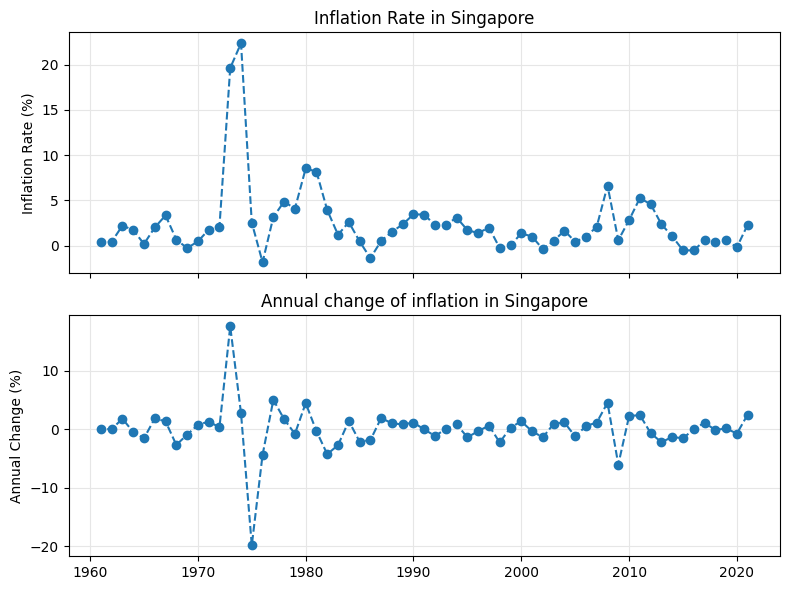

In [4]:
#Using matplotlib.subplots to plot two figures using webscraped data
#Share the same x axis (Year) for both figures 
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6),sharex=True)

#Plotting Figure 1: Inflation Rate in Singapore
ax1.plot(df['Year'],df['Inflation Rate'],linestyle='dashed',marker='o',markersize=6)
ax1.set_title('Inflation Rate in Singapore')
ax1.set_ylabel('Inflation Rate (%)')
ax1.grid(color=(.9,.9,.9))

#Plotting Figure 2: Annual change of inflation in Singapore
ax2.plot(df['Year'],df['Annual Change'],linestyle='dashed',marker='o',markersize=6)
ax2.set_title('Annual change of inflation in Singapore')
ax2.set_ylabel('Annual Change (%)')
ax2.grid(color=(.9,.9,.9))

#Using tight layout to look more presentable (Can be ignored)
plt.tight_layout()

In [5]:
DATA_DIR = "Data"

RESIDENTIAL_CSV = f"{DATA_DIR}/ExecutiveCondoTransaction.csv"
COMMERCIAL_CSV = F"{DATA_DIR}/OfficeTransaction.csv"
INDUSTRIAL_CSV = F"{DATA_DIR}/WarehouseTransaction.csv"

In [6]:
residential_df:pd.DataFrame = pd.read_csv(RESIDENTIAL_CSV)
commercial_df:pd.DataFrame = pd.read_csv(COMMERCIAL_CSV)
industrial_df:pd.DataFrame = pd.read_csv(INDUSTRIAL_CSV)

all_dfs = {
    "residential": residential_df,
    "commercial": commercial_df,
    "industrial": industrial_df
}

for df_name in all_dfs:
    df = all_dfs[df_name]
    df = df.dropna()
    df["Sale Date"] = pd.DatetimeIndex(df["Sale Date"]).year
    df["Unit Price ($ PSF)"] = df["Unit Price ($ PSF)"].replace(",", "", regex=True)
    df["Unit Price ($ PSF)"] = pd.to_numeric(df["Unit Price ($ PSF)"])
    all_dfs[df_name] = df

In [7]:
for df_name in all_dfs:
    all_dfs[df_name] = all_dfs[df_name].groupby(["Planning Region","Sale Date"]).mean()

C:\Users\shkan\AppData\Local\Temp\ipykernel_17980\481731920.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_dfs[df_name] = all_dfs[df_name].groupby(["Planning Region","Sale Date"]).mean()
C:\Users\shkan\AppData\Local\Temp\ipykernel_17980\481731920.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_dfs[df_name] = all_dfs[df_name].groupby(["Planning Region","Sale Date"]).mean()
C:\Users\shkan\AppData\Local\Temp\ipykernel_17980\481731920.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either spe

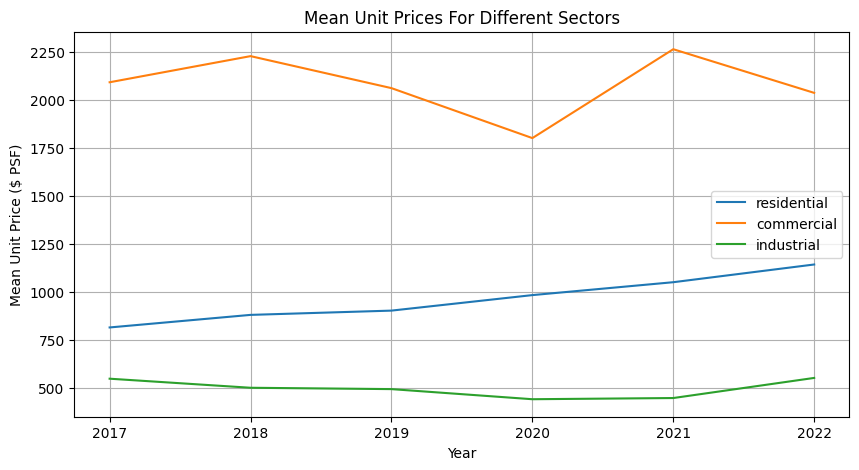

In [8]:
plt.figure(figsize=(10,5))
for i, df_name in enumerate(all_dfs):
    df = all_dfs[df_name]
    y = df.groupby("Sale Date").mean()["Unit Price ($ PSF)"]
    plt.plot(y, label=df_name)
    plt.legend()


plt.title('Mean Unit Prices For Different Sectors')
plt.xlabel('Year')
plt.ylabel('Mean Unit Price ($ PSF)')
plt.grid()
plt.show()


AttributeError: 'bool' object has no attribute 'index'

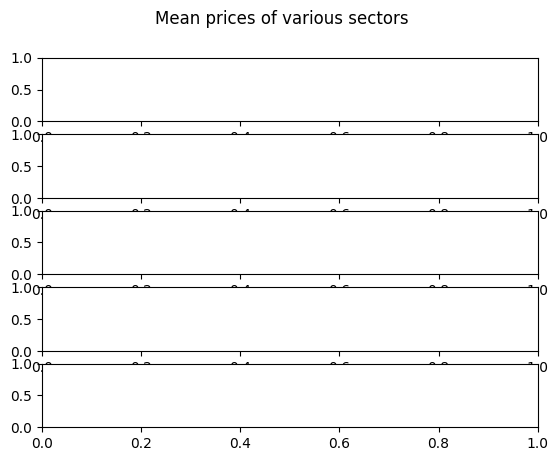

In [11]:
planning_regions = [
    "Central Region",
    "East Region",
    "North East Region",
    "North Region",
    "West Region"
]
   
fig, axs = plt.subplots(len(planning_regions))
fig.suptitle('Mean prices of various sectors')

def locate(row, planning_region):
    return row.index.values[0] == planning_region

for subplot_index, planning_region in enumerate(planning_regions):
    for i, df_name in enumerate(all_dfs):
        sector_df = all_dfs[df_name]
        for row in sector_df.rows:
            if row.index.values[0] != planning_region:
                df.row.


        y = df["Unit Price ($ PSF)"]
        axs[subplot_index].plot(y, label=df_name)
        axs[subplot_index].legend()

plt.show()


In [ ]:
df in all_dfs

grouopby [planning region, sale date]

pr
df= df.loc(df[planning region] == pr)

In [ ]:
for df in all_dfs.values():
    print(df)
    break

                             Unit Price ($ PSF)  Area (SQM)  Number of Units  \
Planning Region   Sale Date                                                    
Central Region    2017              1050.750000  113.875000              1.0   
                  2018              1129.238095  122.380952              1.0   
                  2019              1154.357143  129.571429              1.0   
                  2020              1176.333333  123.833333              1.0   
                  2021              1223.000000  126.833333              1.0   
                  2022              1353.750000  127.500000              1.0   
East Region       2017               711.457143  118.142857              1.0   
                  2018               756.129032  117.088710              1.0   
                  2019               832.072993  108.518248              1.0   
                  2020               890.243902  104.668990              1.0   
                  2021              1077

In [ ]:
residential_df.head()

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Address,Type of Sale,Type of Area,Area (SQM),Unit Price ($ PSM),...,Property Type,Number of Units,Tenure,Completion Date,Purchaser Address Indicator,Postal Code,Postal District,Postal Sector,Planning Region,Planning Area
0,BLOSSOM RESIDENCES,"750,000",753.48,995,2019,30 SEGAR ROAD #04-01,Resale,Strata,70,"10,714",...,Executive Condominium,1,99 yrs from 02/03/2011,2014,Private,677721,23,67,West Region,Bukit Panjang
1,PIERMONT GRAND,"1,478,400","1,334.74",1108,2019,26 SUMANG WALK #05-11,New Sale,Strata,124,"11,923",...,Executive Condominium,1,99 yrs from 04/06/2018,Uncompleted,HDB,828618,19,82,North East Region,Punggol
2,AUSTVILLE RESIDENCES,"860,000","1,033.34",832,2019,19 SENGKANG EAST AVENUE #05-19,Resale,Strata,96,"8,958",...,Executive Condominium,1,99 yrs from 24/08/2010,2014,Private,544808,19,54,North East Region,Sengkang
3,RIVERPARC RESIDENCE,"995,000","1,076.40",924,2019,96 PUNGGOL DRIVE #13-15,Resale,Strata,100,"9,950",...,Executive Condominium,1,99 yrs from 27/12/2010,2014,HDB,828797,19,82,North East Region,Punggol
4,PIERMONT GRAND,"1,680,200","1,506.96",1115,2019,26 SUMANG WALK #07-10,New Sale,Strata,140,"12,001",...,Executive Condominium,1,99 yrs from 04/06/2018,Uncompleted,HDB,828618,19,82,North East Region,Punggol


In [ ]:
test